In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier # RandomForestClassifier

In [3]:
%matplotlib inline
from sklearn.datasets import make_blobs

Step One

Importing Severe Weather Test Data

In [4]:
# importing test weather data
weather_df = pd.read_csv("Severe Weather Event Data/details/SevereWeatherDetails_appended.csv", low_memory=False)

In [5]:
weather_df.head()

,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON
0,10096222,OKLAHOMA,40.0,1950,April,Tornado,0,0,0,0,250K,0,0.0,NaN,F3,3.4,400.0,35.12,-99.20
1,10120412,TEXAS,48.0,1950,April,Tornado,0,0,0,0,25K,0,0.0,NaN,F1,11.5,200.0,31.90,-98.60
2,10104927,PENNSYLVANIA,42.0,1950,July,Tornado,2,0,0,0,25K,0,0.0,NaN,F2,12.9,33.0,40.58,-75.70
3,10104928,PENNSYLVANIA,42.0,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,NaN,F2,0.0,13.0,40.60,-76.75
4,10104929,PENNSYLVANIA,42.0,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,NaN,F0,0.0,33.0,41.63,-79.68


In [6]:
# dropping columns not needed
weather_df = weather_df.drop(columns=['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
                                     'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'TOR_F_SCALE', 'TOR_LENGTH',
                                     'TOR_WIDTH', 'BEGIN_LAT', 'BEGIN_LON', 'STATE_FIPS','STATE','CATEGORY'])

In [7]:
# displaying weather df
weather_df.head()

,EVENT_ID,YEAR,MONTH_NAME,EVENT_TYPE
0,10096222,1950,April,Tornado
1,10120412,1950,April,Tornado
2,10104927,1950,July,Tornado
3,10104928,1950,July,Tornado
4,10104929,1950,July,Tornado


In [8]:
# adding together events by groups
group_groups = weather_df.groupby(['YEAR','MONTH_NAME', 'EVENT_TYPE'], as_index=False).count()
group_groups.head(20)

,YEAR,MONTH_NAME,EVENT_TYPE,EVENT_ID
0,1950,April,Tornado,17
1,1950,August,Tornado,14
2,1950,December,Tornado,6
3,1950,February,Tornado,27
4,1950,January,Tornado,8
5,1950,July,Tornado,23
6,1950,June,Tornado,30
7,1950,March,Tornado,24
8,1950,May,Tornado,64
9,1950,November,Tornado,5


In [9]:
# rename 'EVENT_ID' column as 'Count' and 'YEAR' as 'Year'
group_groups = group_groups.rename(columns={'EVENT_ID': 'Count', 'YEAR': 'Year'})
group_groups.head()

,Year,MONTH_NAME,EVENT_TYPE,Count
0,1950,April,Tornado,17
1,1950,August,Tornado,14
2,1950,December,Tornado,6
3,1950,February,Tornado,27
4,1950,January,Tornado,8


In [14]:
# Co2 Below This

In [15]:
# importing test co2 data 
carbon_df = pd.read_csv("co2_byYear.csv", low_memory=False)

In [16]:
# display co2 data
carbon_df

,year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [17]:
# rename columns for merging purposes
carbon_df = carbon_df.rename(columns={"year": "Year"})
carbon_df

,Year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [18]:
# dropping columns not needed
carbon_df = carbon_df.drop(columns=['co2_per_unit_energy', 'coal_co2', 'cement_co2', 'flaring_co2', 'gas_co2',
                                         'oil_co2', 'other_industry_co2', 'ghg_per_capita', 'methane', 'methane_per_capita',
                                         'nitrous_oxide', 'nitrous_oxide_per_capita', 'population', 'gdp', 'primary_energy_consumption',
                                         'energy_per_capita', 'energy_per_gdp', 'total_ghg'])

In [19]:
# show new dataframe
carbon_df

,Year,co2,co2_per_capita
0,1950,23193.336,943.286
1,1951,24765.194,1214.978
2,1952,25203.424,834.737
3,1953,25929.893,880.578
4,1954,26744.552,1378.627
...,...,...,...
66,2016,124705.642,1156.831
67,2017,126304.716,1156.251
68,2018,128452.538,1152.783
69,2019,128422.887,1165.000


In [20]:
# Merge attempt one
combo_df = group_groups.merge(carbon_df, left_on='Year', right_on='Year')

In [21]:
# checking merge
combo_df

,Year,MONTH_NAME,EVENT_TYPE,Count,co2,co2_per_capita
0,1950,April,Tornado,17,23193.336,943.286
1,1950,August,Tornado,14,23193.336,943.286
2,1950,December,Tornado,6,23193.336,943.286
3,1950,February,Tornado,27,23193.336,943.286
4,1950,January,Tornado,8,23193.336,943.286
...,...,...,...,...,...,...
9281,2020,September,Tropical Storm,34,121592.746,1076.428
9282,2020,September,Waterspout,31,121592.746,1076.428
9283,2020,September,Wildfire,80,121592.746,1076.428
9284,2020,September,Winter Storm,93,121592.746,1076.428


In [29]:
# Print out the # of yearly events value counts
count_counts = combo_df.Count.value_counts()
count_counts

2       394
3       370
4       285
5       283
6       213
       ... 
2370      1
323       1
475       1
499       1
1983      1
Name: Count, Length: 1060, dtype: int64

In [33]:
count_counts.head()

2    394
3    370
4    285
5    283
6    213
Name: Count, dtype: int64

<AxesSubplot:ylabel='Density'>

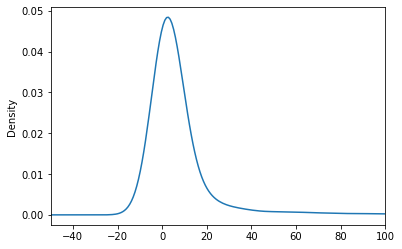

In [32]:
# Visualize the value counts
count_counts.plot.density(xlim=(-50,100))

In [ ]:
# Determine which values to replace
replace_counts = list(count_counts[count_counts < 3].index)

# Replace in DataFrame
for count in replace_counts:
    combo_df.Count = combo_df.Count.replace(count,"Other")


# Check to make sure binning was successful
combo_df.Country.value_counts()

In [22]:
# Adding machine learning model parameters below here

In [23]:
target = ["Count"]

In [24]:
# split data into training and testing

# Create our features
X = pd.get_dummies(combo_df.drop(columns="Count"))

# Create our target
y = pd.get_dummies(combo_df["Count"])

In [25]:
X.describe()

,Year,co2,co2_per_capita,MONTH_NAME_April,MONTH_NAME_August,MONTH_NAME_December,MONTH_NAME_February,MONTH_NAME_January,MONTH_NAME_July,MONTH_NAME_June,...,EVENT_TYPE_Tornado,EVENT_TYPE_Tropical Depression,EVENT_TYPE_Tropical Storm,EVENT_TYPE_Tsunami,EVENT_TYPE_Volcanic Ash,EVENT_TYPE_Volcanic Ashfall,EVENT_TYPE_Waterspout,EVENT_TYPE_Wildfire,EVENT_TYPE_Winter Storm,EVENT_TYPE_Winter Weather
count,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,...,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000,9286.000000
mean,2003.215809,104310.862073,1187.377204,0.086474,0.075598,0.086259,0.088413,0.089274,0.073229,0.076567,...,0.089813,0.002800,0.009154,0.000538,0.000969,0.000323,0.030368,0.029830,0.022292,0.023045
std,14.989386,23549.467913,75.595101,0.281078,0.264368,0.280761,0.283909,0.285154,0.260525,0.265917,...,0.285929,0.052843,0.095241,0.023199,0.031119,0.017972,0.171608,0.170127,0.147638,0.150056
min,1950.000000,23193.336000,834.737000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1999.000000,90524.433000,1152.783000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,112661.081000,1185.569000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,124342.031000,1226.914000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,128452.538000,1523.389000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# Check the balance of our target values
y = combo_df['Count']
y.value_counts()

2       394
3       370
4       285
5       283
6       213
       ... 
2370      1
323       1
475       1
499       1
1983      1
Name: Count, Length: 1060, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# resample the training data with the BalancedRandomForestClassifier

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brfc.fit(X_train_scaled, y_train)

In [ ]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = brfc.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
# calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

In [ ]:
# print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

In [ ]:
# list the features sorted in descending order by feature importance
sorted(zip(brfc.feature_importances_, X.columns), reverse=True)